# Investigación de modelos ML

Se busca predecir de clientes que dejarán o se quedarán siendo clientes de nuestra empresa bancaria.

Trata de un problema de clasificación binaria.

Departamento de modelos

In [1]:
import pandas as pd

# Cargar los datos
data = pd.read_csv('data_selected.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13198 entries, 0 to 13197
Data columns (total 8 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  13198 non-null  float64
 1    ROA(B) before interest and depreciation after tax        13198 non-null  float64
 2    Persistent EPS in the Last Four Seasons                  13198 non-null  float64
 3    Per Share Net profit before tax (Yuan ¥)                 13198 non-null  float64
 4    Debt ratio %                                             13198 non-null  float64
 5    Net worth/Assets                                         13198 non-null  float64
 6    Net profit before tax/Paid-in capital                    13198 non-null  float64
 7   Bankrupt?                                                 13198 non-null  int64  
dtypes: float64(7), in

In [2]:
data.head()

,ROA(C) before interest and depreciation before interest,ROA(B) before interest and depreciation after tax,Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Debt ratio %,Net worth/Assets,Net profit before tax/Paid-in capital,Bankrupt?
0,0.521620,0.567803,0.234944,0.187542,0.121928,0.878072,0.186555,0
1,0.437089,0.470207,0.185024,0.148753,0.207576,0.792424,0.147772,1
2,0.549798,0.601156,0.256500,0.208255,0.140067,0.859933,0.206960,0
3,0.446644,0.494887,0.201853,0.161106,0.153793,0.846207,0.160094,1
4,0.506021,0.564645,0.231918,0.183551,0.195090,0.804910,0.181977,1


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Dividir en features y target
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
# Realizar predicciones
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [22]:
# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC ROC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9901515151515151
AUC ROC: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1320
           1       0.98      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640



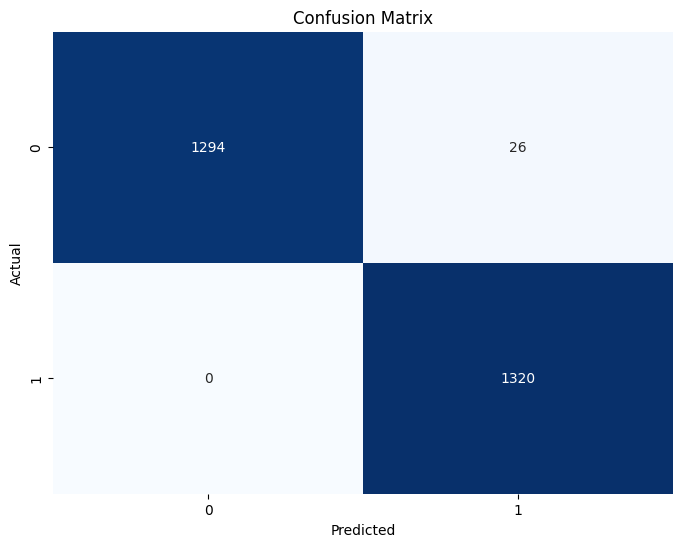

In [23]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Importancia de características
feature_importance = pd.DataFrame(
    {'feature': X.columns, 'importance': rf_model.feature_importances_}
).sort_values('importance', ascending=False)

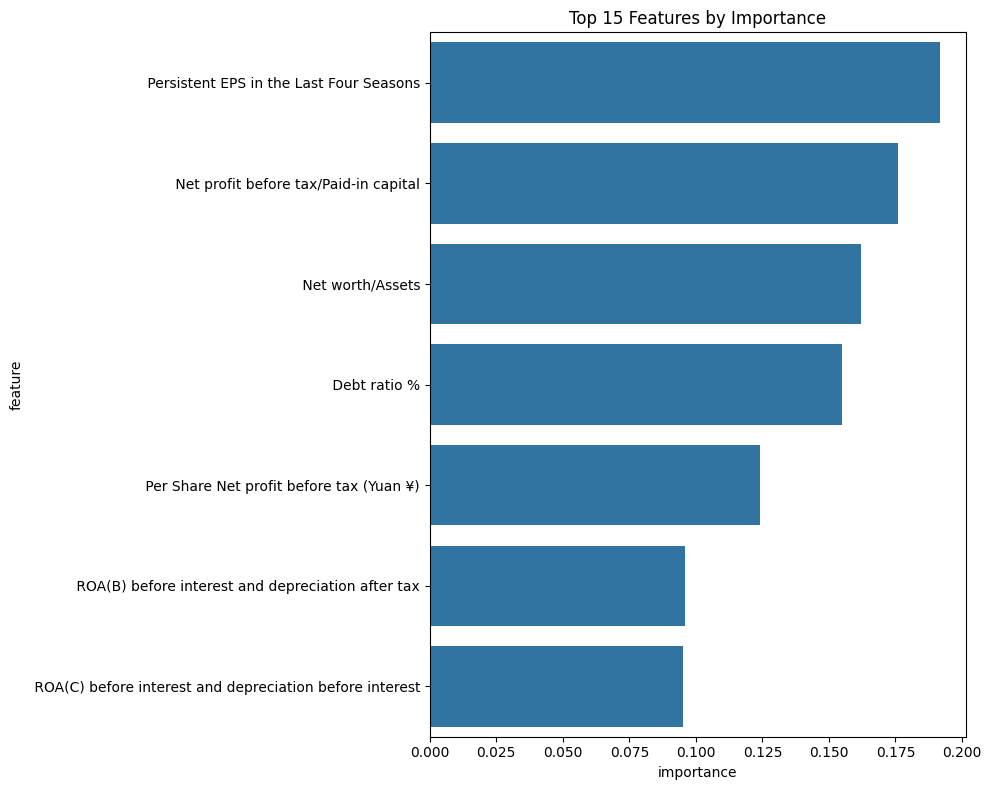

In [25]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

Importancia de cada una de las características

In [26]:
# Validación cruzada para una estimación más robusta
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validated AUC ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validated AUC ROC: 1.0000 ± 0.0000


Top 5 features by permutation importance:
                                             feature  importance
2            Persistent EPS in the Last Four Seasons    0.322197
6              Net profit before tax/Paid-in capital    0.309811
5                                   Net worth/Assets    0.255644
1   ROA(B) before interest and depreciation after...    0.248220
4                                       Debt ratio %    0.236098
Dummy classifier accuracy: 0.5
Logistic regression AUC: 0.9240174471992654
AUC with different seeds: 1.0000 ± 0.0000

Correlation with target:
Bankrupt?                                    1.000000
 Debt ratio %                                0.580280
 Per Share Net profit before tax (Yuan ¥)   -0.527592
 Net profit before tax/Paid-in capital      -0.532709
 Persistent EPS in the Last Four Seasons    -0.546117
 Net worth/Assets                           -0.580280
Name: Bankrupt?, dtype: float64


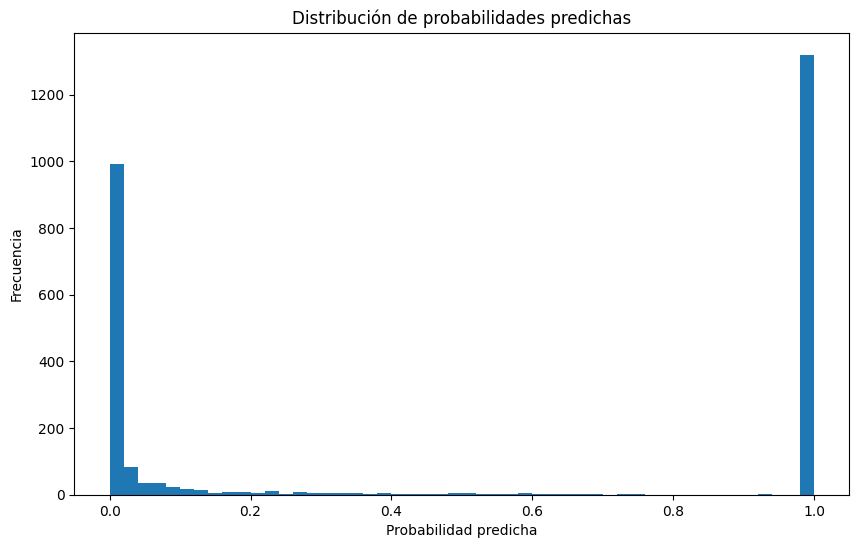

In [27]:
# 1. Prueba de permutación para detectar fuga de datos
from sklearn.inspection import permutation_importance
import numpy as np

# Evaluar importancia por permutación
r = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({'feature': X.columns, 'importance': r.importances_mean}).sort_values('importance', ascending=False)
print("Top 5 features by permutation importance:")
print(perm_importance.head(5))

# 2. Comparar con modelos más simples
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Modelo básico de referencia (predice siempre la clase mayoritaria)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print(f"Dummy classifier accuracy: {dummy.score(X_test, y_test)}")

# Modelo simple (regresión logística)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(f"Logistic regression AUC: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

# 3. Validación con diferentes semillas
seeds = [42, 123, 456, 789, 101112]
cv_results = []

for seed in seeds:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    model_s = RandomForestClassifier(n_estimators=100, random_state=seed)
    model_s.fit(X_train_s, y_train_s)
    auc = roc_auc_score(y_test_s, model_s.predict_proba(X_test_s)[:,1])
    cv_results.append(auc)

print(f"AUC with different seeds: {np.mean(cv_results):.4f} ± {np.std(cv_results):.4f}")

# 4. Análisis de correlación de características importantes
top_features = list(feature_importance['feature'].head(5))
correlation = data[top_features + ['Bankrupt?']].corr()
print("\nCorrelation with target:")
print(correlation['Bankrupt?'].sort_values(ascending=False))

# 5. Prueba holdout extrema - validación temporal si los datos tienen fecha
# Si tienes una columna de fecha, ordena por fecha y prueba el modelo en datos más recientes
# data_sorted = data.sort_values('date_column')
# train_data = data_sorted.iloc[:int(len(data_sorted)*0.7)]
# test_data = data_sorted.iloc[int(len(data_sorted)*0.7):]

# 6. Verificar distribución de probabilidades predichas
probs = rf_model.predict_proba(X_test)[:,1]
plt.figure(figsize=(10, 6))
plt.hist(probs, bins=50)
plt.title('Distribución de probabilidades predichas')
plt.xlabel('Probabilidad predicha')
plt.ylabel('Frecuencia')
plt.show()

# Si todas las probabilidades son 0 o 1, esto sugiere un problema

In [28]:
print(f"CÓMO PREDECIR CON ESTE MODELO RF:\n\n Paso 1.- Carga de datos ya preprocesados.\n PASO 2.- Entrenar modelo.\n PASO 3.- Predicciones con RF y validaciones 1.\n\nAsegúrense de meter esto en score.py")


import pickle

# Guardar el modelo entrenado
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

CÓMO PREDECIR CON ESTE MODELO RF:

 Paso 1.- Carga de datos ya preprocesados.
 PASO 2.- Entrenar modelo.
 PASO 3.- Predicciones con RF y validaciones 1.

Asegúrense de meter esto en score.py
